In [2]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio
from astropy.io import fits
from astropy import wcs

from multiprocessing import Pool
import argparse

from scipy.interpolate import RectBivariateSpline
from scipy.ndimage.filters import gaussian_filter
from scipy import stats

In [3]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'}
plt.rcParams.update(params)

In [4]:

nmad = lambda x: 1.4826 * np.median(np.abs(x-np.median(x)))

ccdnamenumdict = {'S1': 25, 'S2': 26, 'S3': 27, 'S4':28,
                  'S5': 29, 'S6': 30, 'S7': 31,
                  'S8': 19, 'S9': 20, 'S10': 21, 'S11': 22, 'S12': 23,
                  'S13': 24,
                  'S14': 13, 'S15': 14, 'S16': 15, 'S17': 16, 'S18': 17,
                  'S19': 18,
                  'S20': 8, 'S21': 9, 'S22': 10, 'S23': 11, 'S24': 12,
                  'S25': 4, 'S26': 5, 'S27': 6, 'S28': 7,
                  'S29': 1, 'S30': 2, 'S31': 3,
                  'N1': 32, 'N2': 33, 'N3': 34, 'N4': 35,
                  'N5': 36, 'N6': 37, 'N7': 38,
                  'N8': 39, 'N9': 40, 'N10': 41, 'N11': 42, 'N12': 43,
                  'N13': 44,
                  'N14': 45, 'N15': 46, 'N16': 47, 'N17': 48, 'N18': 49,
                  'N19': 50,
                  'N20': 51, 'N21': 52, 'N22': 53, 'N23': 54, 'N24': 55,
                  'N25': 56, 'N26': 57, 'N27': 58, 'N28': 59,
                  'N29': 60, 'N30': 61, 'N31': 62,
                  }
ccdnamenumdict_inv = {aa: bb for bb, aa in ccdnamenumdict.items()}

fringe_old_dir = '/global/homes/d/djschleg/cosmo/staging/decam/DECam_CP-Fringe'
fringe_new_dir = '/global/project/projectdirs/desi/users/rongpu/dr9/fringe/DECam_CP-Fringe'
image_dir = '/global/project/projectdirs/cosmo/staging/'
surveyccd_path = '/global/project/projectdirs/cosmo/work/legacysurvey/dr9/survey-ccds-decam-dr9-cut.fits.gz'
# surveyccd_path = '/global/homes/r/rongpu/mydesi/dr9/fringe/temp/survey-ccds-decam-dr9-z-band-only-trim.fits'
blob_dir = '/global/cscratch1/sd/rongpu/fringe/decam_ccd_blob_mask'

# image_output_dir = '/global/cscratch1/sd/rongpu/fringe/fringe_corrected_image/'
frgscale_output_dir = '/global/cscratch1/sd/rongpu/fringe/frgscale/'
# image_output_dir = '/global/cscratch1/sd/rongpu/fringe/tmp_img/'
# frgscale_output_dir = '/global/cscratch1/sd/rongpu/fringe/tmp_frgscale/'

##############################################################################################################################

# Load CCD list
ccd_columns = ['image_filename', 'image_hdu', 'expnum', 'ccdname', 'filter', 'ccd_cuts']
# ccd = fitsio.read(surveyccd_path, columns=ccd_columns)
ccd = fitsio.read(surveyccd_path)
ccd = Table(ccd)
mask = ccd['ccd_cuts']==0
mask &= ccd['filter']=='z' # include only z-band images
ccd = ccd[mask]
print(len(ccd))
ccd['ccdnum'] = [ccdnamenumdict[ccd['ccdname'][ii].strip()] for ii in range(len(ccd))]

expnum_list = np.unique(ccd['expnum'])
print(len(expnum_list))

1148265
19019


__Fringe fitting status:__

In [5]:
expnum_list_done = np.zeros(len(expnum_list), dtype=bool)

for index, expnum in enumerate(expnum_list):

    # Find an arbitrary CCD in the exposure to get the image filename
    ccd_index = np.where((ccd['expnum']==expnum))[0][0]

    frgscale_output_path = os.path.join(frgscale_output_dir, ccd['image_filename'][ccd_index].strip().replace('.fits.fz', '.txt'))
    if os.path.isfile(frgscale_output_path):
        expnum_list_done[index] = True

print(np.sum(expnum_list_done), np.sum(~expnum_list_done), np.sum(expnum_list_done)/len(expnum_list_done))

19019 0 1.0


0


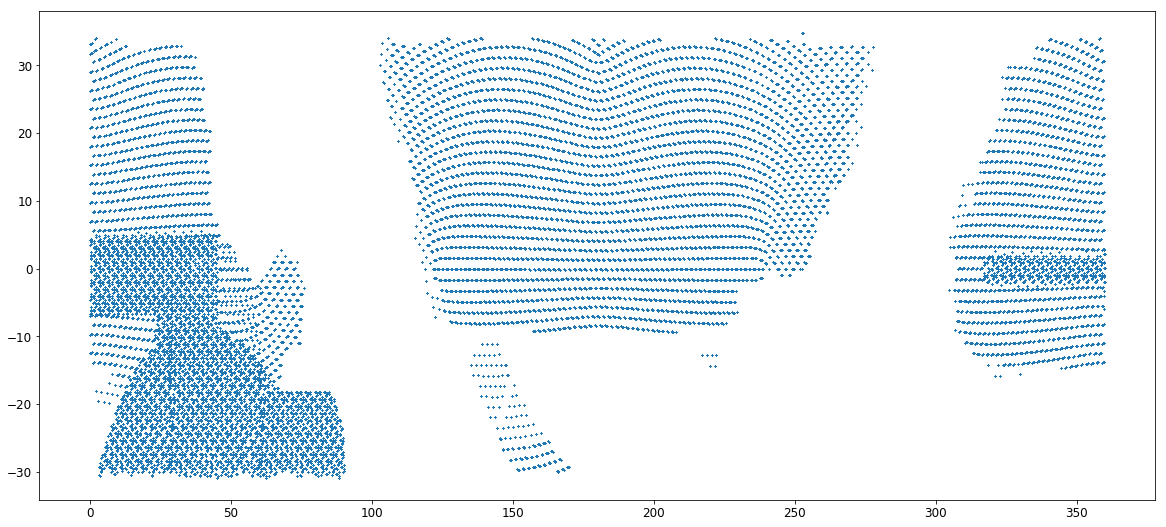

In [9]:
mask = np.in1d(ccd['expnum'], expnum_list[~expnum_list_done])
print(np.sum(mask))

plt.figure(figsize=(20, 9))
plt.plot(ccd['ra_bore'][~mask], ccd['dec_bore'][~mask], '.', ms=0.5)
plt.plot(ccd['ra_bore'][mask], ccd['dec_bore'][mask], '.', ms=1)
plt.show()

__Blobmask status:__

In [6]:
expnum_list_done = np.zeros(len(expnum_list), dtype=bool)

for index, expnum in enumerate(expnum_list):

    # Find an arbitrary CCD in the exposure to get the image filename
    ccd_index = np.where((ccd['expnum']==expnum))[0][0]

    str_loc = str.find(ccd['image_filename'][ccd_index].strip(), '.fits')
    img_filename_base = ccd['image_filename'][ccd_index].strip()[:str_loc]
    blob_path = os.path.join(blob_dir, 'blob_mask', img_filename_base+'-blobmask.npz')
    if os.path.isfile(blob_path):
        expnum_list_done[index] = True

print(np.sum(expnum_list_done), np.sum(~expnum_list_done), np.sum(expnum_list_done)/len(expnum_list_done))

19019 1.0


------------